# Computer Vision - Assignment 2 - Deep Learning for Computer Vision

#### 10 points   |   Due date: November 26, 23:59   |   Submission site: https://pradogrado2324.ugr.es/

### Student's Full Name: GONZÁLEZ DURÁN, DAVID

The goal of this assignment is to learn how to implement and use Convolutional Neural Networks using the fastai library (https://docs.fast.ai/).

<font color=#80BEF1>The goal of this assignmnet is to gain experience designing and training deep neural networks (in particular, convolutional neural networks). From a base network architecture that is provided, you have to learn to perform experiments with it and to improve it by adding, modifying or deleting layers.

<font color=#80BEF1>A help guide (`Assignment_2_HG.ipynb`) is also provided to know how:
1. Basic functions of reading data, training and optimization can be performed;
2. Graphs for the evolution of the classification error in
the training and validation sets can be created;
3. The classification error in the test set can be computed.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 943.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.4 MB/s eta 0:00:00
Mounted at /content/gdrive
fastcore version 1.5.29 installed
fastai version 2.7.13 installed


In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color=#80BEF1>**Exercise 1: BaseNet in CIFAR100 (3 points)**

<font color=#80BEF1>*Dataset:*
In this exercise, we will work with part of the CIFAR100 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 60K color images of 32x32x3 (RGB) depicting 100 different classes (600 images per class). There are 50K images for training and 10K for testing. For the development of the exercise we will only consider 25 classes (out of 100). Therefore, **the training set has 12,500 images** **and the test set 2,500 images**. **10% of the training set will be used for validation**.

<font color=#80BEF1>**Model BaseNet:**
We start by creating a base model called *BaseNet* which, after its training and execution, will give us a classification error which will be used as reference or baseline for further improvements.

<font color=#80BEF1>Our BaseNet model consists of two convolutional blocks (Conv+ReLU) at different scales (MaxPooling), and one head composed of two fully-connected (FC) layers (also called dense layers). The precise architecture is defined in the table below:

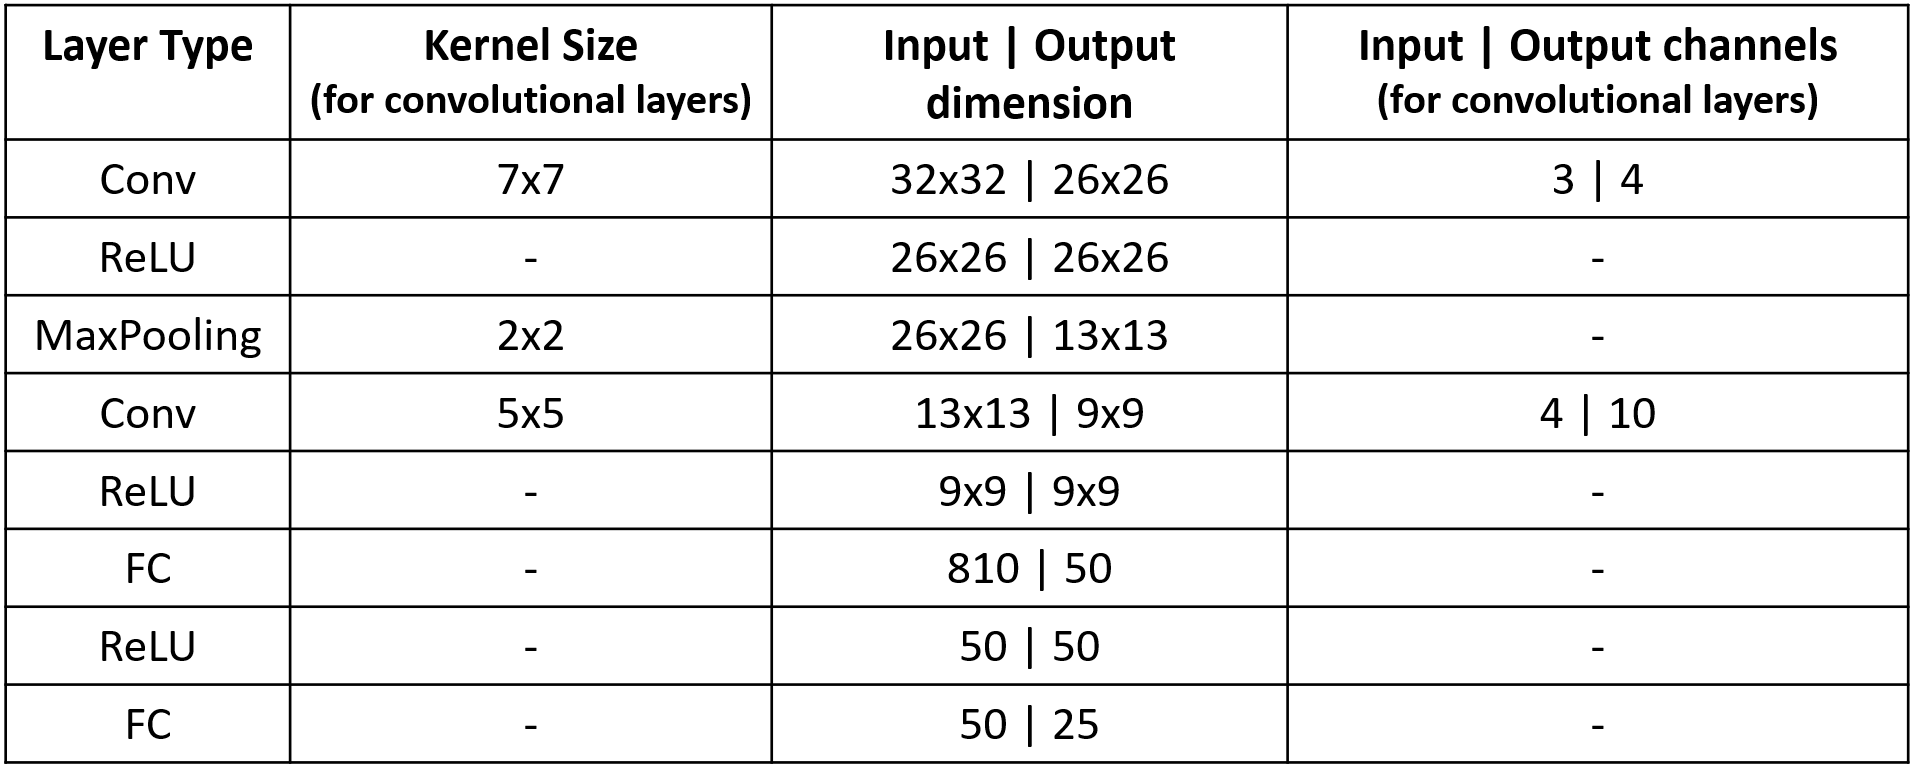


<font color=#80BEF1>The students must:
1. Become familiar with the *BaseNet* architecture described above, the meaning of the different hyperparameters and the purpose of each layer. Create the code for the *BaseNet* model employing the fastai library.
2. Train the model (justifying all decisions made) and evaluate its performance. To do so, you should employ: the confusion matrix in training and testing; the accuracy in training, validation and test; and the evolution of both the loss function (in training and validation) and accuracy (in validation) with respect to the training epochs.

<font color=#80BEF1>Note: This is the base model that we will try to improve in the next section. In this sense, it is not necessary to carry out a very sophisticated or complex training procedure. In any case, it is not advisable to use the default values of functions without having a justification for it. One must demonstrate that he/she understands what is doing, as well as what the framework does underneath.

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/vehicles_1'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/large_carnivores'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/


"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)." https://github.com/fastai/dlcert2/blob/master/docs/datasets.md

In [ ]:
# We want to verify that within each of the 20 superclasses there are 5 classes,
# which gives the 100 classes there are. We also want to verify that the number of images is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Number of classes within superclass ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/non-insect_invertebrates ):  [Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/spider'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/crab'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/worm'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/snail'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/lobster')]
Number of classes within superclass  0 :  5
Number of classes within superclass  1 :  5
Number of classes within superclass  2 :  5
Number of classes within superclass  3 :  5
Number of classes within superclass  4 :  5
Number of classes within superclass  5 :  5
Number of classes within superclass  6 :  5
Number of classes within superclass  7 :  5
Number of classes within superclass  8 :  5
Number of classes within superclass  9 :  5
Number of classes within superclass  10 :  5
Number of classes within superclass  11 : 

In [ ]:
# We keep the first 25 classes (we remove the last 75 from the dataset)
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('REMOVED SUPERCLASSES:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASSES WE KEEP:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

REMOVED SUPERCLASSES:
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/trees
SUPERCLASSES WE KEEP:
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/insect

In [ ]:
# We also remove the classes from the test set
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/reptiles
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/medium_mammals
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/people
/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/trees


In [ ]:
# Now we check if we have remove them correctly
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


In [ ]:
# And that the number of examples in training and test is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/non-insect_invertebrates ):  [Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/spider'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/crab'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/worm'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/snail'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates/lobster')]
Total training images:  12500
Total test images:  2500


Una vez con los datos de train y test separados, necesitamos adecuar los datos de entrenamiento para alimentar nuestro modelo.

Para esto, utilizaremos una instancia de `DataBlock`, una clase proporcionada por fastai. Un `DataBlock` no es más que un conjunto de normas para cargar imágenes, que define una estructura de bloques de imágenes y sus etiquetas, unas reglas de división en conjuntos de entrenamiento y validación, y aplica unas transformaciones tanto a nivel de elemento (imagen por separado) como de batch para preparar los datos para el entrenamiento de un modelo.

In [ ]:
dlblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            splitter=RandomSplitter(valid_pct=0.2, seed=42),
            get_y=parent_label,
            item_tfms=[Resize((32,32), method='squish')],
            batch_tfms=Normalize.from_stats(*imagenet_stats)
          )

En nuestro `DataBlock` hemos especificado lo siguiente:

1. En `blocks=(ImageBlock, CategoryBlock)` se especifica que los bloques de datos consisten en un bloque de imagen y un bloque de categoría para las etiquetas.

NOTA: En nuestro caso, asignamos una etiqueta a cada imagen, razón por la cual empleamos `CategoryBlock` en lugar de `MultiCategoryBlock`. Este último se utilizaría en escenarios donde se deben asignar múltiples etiquetas, como en el caso de problemas de segmentación de imágenes.

2. La configuración `get_items=get_image_files` especifica que las imágenes a utilizar se obtendrán mediante la función `get_image_files`. Esta función recopila las imágenes de manera recursiva desde la ruta especificada, incluyendo el directorio principal y sus subdirectorios. Esta función se utilizará de manera automática cuando carguemos los datos con el método `dataloaders`, con el path que indiquemos.

3. `splitter=RandomSplitter(valid_pct=0.2, seed=42)` nos dividirá los datos aleatoriamente en entrenamiento y validación, en proporción 80-20 %, respectivamente.

3. `get_y=parent_label`: Se utiliza la función `parent_label` para obtener las etiquetas de las imágenes a partir de la estructura de directorios.

4. `item_tfms=[Resize((32,32), method='crop')]`: Las transformaciones de elementos se aplican a las imágenes antes de cargarlas en el conjunto de datos. Si bien sabemos que todas las imágenes son de 32x32, esta práctica garantiza de manera consistente que todas cumplan con esta dimensión específica. Empleamos el método 'crop', que recorta la imagen para que tenga las dimensiones deseadas, manteniendo la región central de la imagen original.

5. `batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()]`: Las transformaciones de lotes se aplican después de cargar las imágenes en lotes. En nuestro caso hemos aplicado una transformación:
  - **Normalización**, que ajusta los valores de píxeles de las imágenes para que tengan una media y desviación estándar de las imágenes de la base de datos ImageNet. La normalización es crucial para estandarizar los datos y mejorar la convergencia del modelo durante el entrenamiento.

  NOTA: La media y desviación estándar que tenga `imagenet_stats` no tienen por qué corresponderse con la media y la desviación estándar de nuestro conjunto de imágenes, pero puede ser interesante utilizar los valores de ImageNet, ya que es una base de datos con una gran cantidad de imágenes, muy general, y por tanto, poco sesgada.

A continuación, empleamos el bloque de datos previamente definido, `dlblock`, para generar un objeto `DataLoaders` específico para nuestro conjunto de datos, indicando la ruta donde se encuentran las imágenes y etiquetas.

Cargamos únicamente las imágenes del conjunto 'train', que abarca tanto las imágenes de entrenamiento como las de validación para nuestro modelo.

A diferencia de `DataBlock`, el objeto `DataLoaders` sí contiene imágenes, que ya han sido cargadas, preprocesadas y organizadas conforme a las reglas del objeto `DataBlock`. `DataLoaders` permite agrupar tanto los datos de entrenamiento como los de validación, así como facilita la gestión de los conjuntos de datos.

Además de la explicación proporcionada, el **tamaño del lote (*batch size*)** es un aspecto crucial al trabajar con DataLoaders en el aprendizaje profundo. El tamaño del lote se refiere a la cantidad de ejemplos de entrenamiento que se utilizan en una iteración para actualizar los pesos del modelo (mediante *back propagation*).

El tamaño correcto para un batch es us un tema ampliamente debatido en el campo del aprendizaje automático. Influye en varios aspectos del entrenamiento del modelo, como la velocidad de convergencia, el uso de la memoria y la estabilidad del proceso. La determinación de un tamaño de lote óptimo depende de varios factores, incluyendo el tamaño y la complejidad del conjunto de datos, la capacidad de la memoria disponible y las características específicas del modelo de aprendizaje profundo utilizado, así como los valores del resto de hiperparámetros.

El tamaño de bath usado por defecto es de 4, que es el que usaré yo, dado que optar por lotes pequeños puede ayudar a mitigar el riesgo de sobreajuste (overfitting).

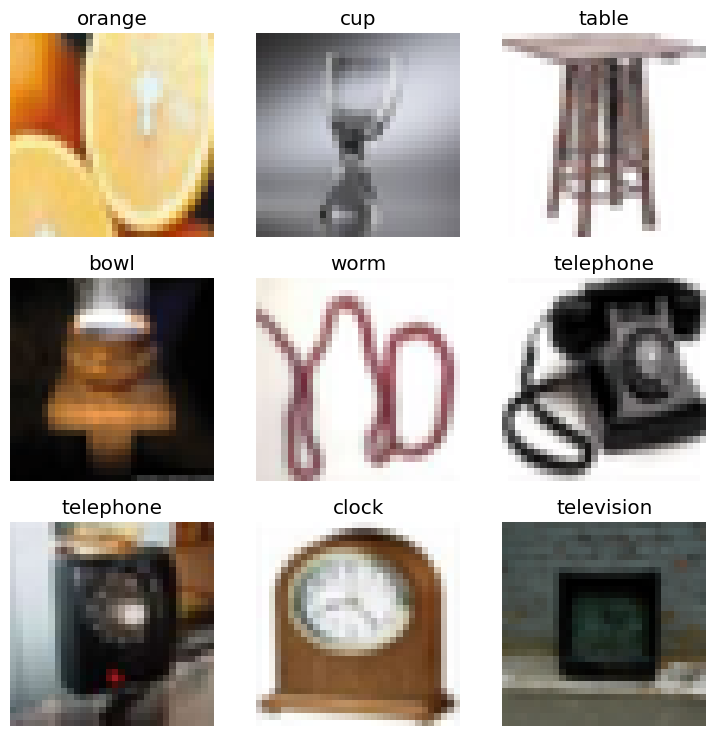

In [ ]:
CIFAR100 = dlblock.dataloaders(path/'train', bs=4)
CIFAR100.show_batch()

Ahora crearemos una red convolucional básica (CNN, *Convolutional Neural Network*), apoyándonos de la clase contenedor de capas neuronales `nn.Sequential`, de Pytorch, que nos permite construir redes neuronales secuenciales de manera sencilla.

Utilizaremos las capas se nos solicitan:

------------------

**CONVOLUCIONALES**

Las capas convolucionales configuran filtros que permiten detectar características en una imagen. Los filtros más pequeños tenderán a capturar características locales y detalles finos en la entrada, y los más grandes tenderán a capturar características más grandes y globales en la entrada.

El número de canales de entrada es 3, uno por canal canal de RGB. Utilizaremos 4 filtros convolucionales, cada uno con los tres canales RGB, de manera que la convolución se realizará sobre los tres canales de cada imagen (convolución 3D).

------------------

**ReLU (Rectified Linear Unit)**

ReLU es una función de activación que retorna cero para todos los valores de entrada negativos y retorna el mismo valor de entrada para todos los valores no negativos.

> **¿Qué es una función de activación?**
>
> Es una función matemática que calcula la salida de una neurona, basado en la entrada y los valores de esta.
> Cuando las neuronas reciben entradas, aplican la función de activación, que determina si la unidad se activará (enviará una señal no nula) o no activará (enviará una señal cercana o igual a cero).

Esto logra reducir la linearidad de las imágenes. "Todos los elementos irrrelevantes son igualmente irrelevantes".

Además, palía el problema de desvacenimiento de gradiente (problema que se manifiesta cuando los gradientes de las capas más profundas de la red son muy pequeños durante la retropropagación, lo que lleva a que los pesos de esas capas no se actualicen de manera significativa).

Esta función se coloca directamente después tanto de las capas convolucionales como de las capas completamente conectadas.

------------------

**POOLING**

Las capas de reducción de muestreo (*pool*) son usadas para realizar submuestreo en las representaciones de las capas anteriores. Esto ayuda a preservar las características más dominantes de una región, permitiendo que el modelo sea invariante a pequeñas traslaciones en la entrada, reduciendo así la sensibilidad a la posición.

El pooling reduce el tamaño espacial (ancho y alto) de la representación, lo que disminuye la cantidad de parámetros y cálculos en las capas subsiguientes. Esto ayuda a controlar el costo computacional y a evitar el sobreajuste.

Hay diversos métodos:
  - **MaxPool**: Para cada región no solapada de `(kernel_size1,kernel_size2)` de tamaño obtiene el mayor valor.
  - **AvgPool**: Para cada región no solapada de `(kernel_size1,kernel_size2)` de tamaño obtiene el valor medio.

------------------

**FLATENNING**

El *flatenning* es una operación sin parámetros entrenables. Transforma un tensor de entrada en un vector unidimensional, que puede ser procesado por las capas Fully Connected, permitiendo así la combinación lineal de las caractrísticas en las capas convolucionales para realizar la clasificación final.

------------------

**FULLY CONNECTED**

Adquiere las características fusionadas de capas convolucionales anteriores, aplicando a cada una un peso, representado por parámetros entrenables, y luego agregando un sesgo. Podría haber múltiples capas fully-connected apiladas.

La última capa de una red neuronal fully-connected debe tener el número de clases de salida deseado porque esta capa se encarga de producir las salidas finales de la red, y cada neurona en esta capa representa una clase específica.

------------------

**SOFTMAX**

Softmax es una función de activación dispuesta en la capa de salida de una red neuronal cuando se  busca realizar una clasificación multiclase, de modo que las probabilidades de todas las clases sumen 1.

------------------

In [ ]:
class BaseNET(nn.Sequential):
  # IT IS KEY HERE TO SET LAYERS SIZES MATCHING THE SPATIAL SIZE OF THE INPUT TENSOR
  # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
  #          groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    def __init__(self):
        super().__init__(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(7,7), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=4, out_channels=10, kernel_size=(5,5), stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=810, out_features=50), # Entran 810 mapas de activación, salen 50
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=25)
        )

# object instantiation
BaseNET_model = BaseNET()
# CHECK the number of parameters and if it’s trainable or not
total_params(BaseNET_model)

(43427, True)

Creamos una instancia de nuestra clase `BaseNet`. Este será nuestro modelo. Ahora debemos entrenarlo.

La clase `Learner` nos permite encapsular todos los componentes necesarios para entrenar nuestro modelo:
- **Modelo de aprendizaje**.
- **Carga de datos**.
- **Función de pérdida**, que mide la disparidad entre las predicciones del modelo y los valores reales del conjunto de datos
- **Optimizador**, función que utiliza información de la función de pérdida para ajustar los valores entrenables, de manera que minimice la pérdida. Por defecto se usa Adam.
- **Métricas a calcular** en el set de validación.

Crearemos una instancia:

In [ ]:
learn = Learner(CIFAR100, BaseNET_model, loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,error_rate])
learn.summary()

BaseNET (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 26 x 26    
Conv2d                                    592        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 4 x 13 x 13    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 10 x 9 x 9     
Conv2d                                    1010       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 810            
Flatten                                                        
____________________________________________________________________________
                     64 x 50        

Podemos comprobar que la inmensa mayoría de parámetros entrenables corresponden a las capas fully-connected, debido a que el número de enlaces es cuadrático, puesto que cada neurona de entrada debe establecer una conexión con con cada neurona de salida.

Para comenzar a entrenar nuestro modelo solo nos queda elegir un método para entrenar el modelo. Optaré por seguir la metodología propuesta por Leslie N. Smith, la cual emplea `fit_one_cycle`. En este contexto, es necesario definir dos parámetros cruciales:

- El **número de épocas**, que indica el número de veces que se recorrerá todo el conjunto de datos durante el entrenamiento.

  Determinar el número óptimo de épocas para entrenar un modelo no tiene una respuesta única y definitiva, ya que depende en gran medida del conjunto de datos, la complejidad del modelo y la naturaleza del problema que estás abordando.

  Yo entrenaré el modelo 25 épocas. Veremos si son o no suficientes épocas en la discusión de la gráfica de pérdida.

- El ***learning rate* máximo**, que influye en la rapidez con la que el modelo ajusta sus pesos durante el proceso de aprendizaje. Smith desarrolló un método de búsqueda de tasa de aprendizaje adecuadas para el entrenamiento de modelos de aprendizaje.

  Este realiza un pequeño entrenamiento del modelo con tasas de aprendizaje en un rango específico y luego plotea la pérdida en función de la tasa de aprendizaje. La idea es encontrar un valor de tasa de aprendizaje que esté en la parte descendente del gráfico antes de que la pérdida comience a aumentar nuevamente.

  Fastai incorpora directamente este método para el objeto Learner, denominado `lr_find`, que es que usaremos.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.132738,3.078445,0.136400,0.863600,00:28
1,2.902428,2.830197,0.165600,0.834400,00:25
2,2.757949,2.755924,0.206000,0.794000,00:30
3,2.652254,2.664881,0.233600,0.766400,00:37
4,2.528869,2.618579,0.247600,0.752400,00:40
5,2.492157,2.577177,0.241200,0.758800,00:39
6,2.419539,2.515398,0.282400,0.717600,00:44
7,2.309925,2.474808,0.289200,0.710800,00:33
8,2.263279,2.460451,0.298000,0.702000,00:29
9,2.169166,2.437047,0.311200,0.688800,00:33


Better model found at epoch 0 with valid_loss value: 3.078444719314575.


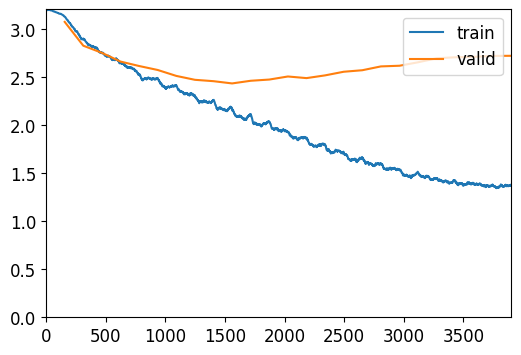

Better model found at epoch 1 with valid_loss value: 2.8301968574523926.
Better model found at epoch 2 with valid_loss value: 2.7559239864349365.
Better model found at epoch 3 with valid_loss value: 2.6648807525634766.
Better model found at epoch 4 with valid_loss value: 2.618579387664795.
Better model found at epoch 5 with valid_loss value: 2.5771772861480713.
Better model found at epoch 6 with valid_loss value: 2.515397787094116.
Better model found at epoch 7 with valid_loss value: 2.47480845451355.
Better model found at epoch 8 with valid_loss value: 2.460451126098633.
Better model found at epoch 9 with valid_loss value: 2.437047243118286.


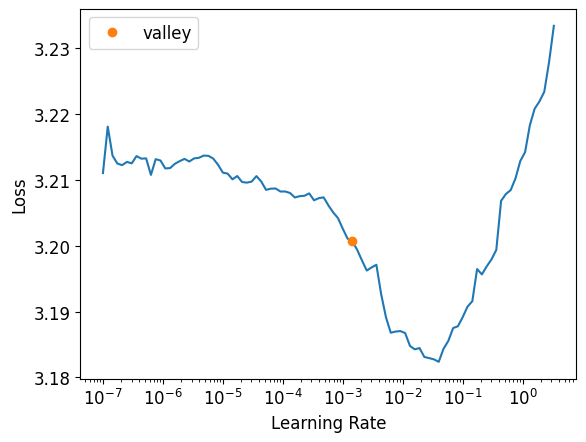

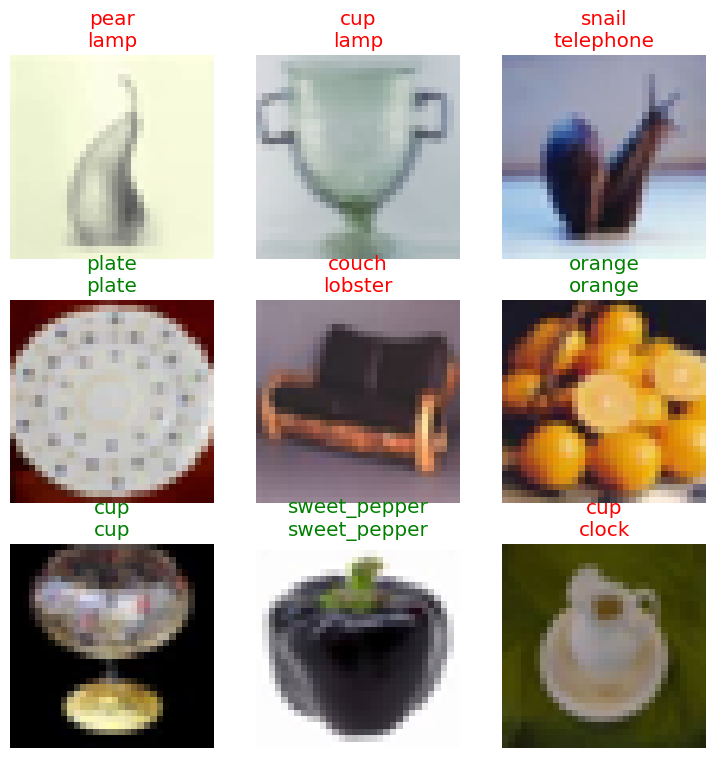

In [ ]:
lr=learn.lr_find()
cbs=[SaveModelCallback(), ShowGraphCallback()]
learn.fit_one_cycle(n_epoch=25, lr_max=lr[0], cbs=cbs)
learn.show_results()

El resultado del entrenamiento es muy pobre. Se ha logrado una tasa de acierto de tan solo el 31,5% en la época 24. Además, podemos apreciar en la **gráfica de pérdida** que se ha dado **sobreajuste (*overfitting*)**, pues el modelo se ha ajustado demasiado a los datos de entrenamiento, capturando patrones específicos de ese conjunto de datos que no generalizan bien a datos nuevos, como los de validación. Notablemente, el sobreajuste se hace evidente a partir de la iteración 1.000, marcado por la divergencia entre las tasas de aciertos en los conjuntos de datos de entrenamiento y validación.

In [ ]:
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]

test_dl = learn.dls.test_dl(test_files,with_labels=True)

In [ ]:
# We perform prediction on this bunch of data (in this case, the test set)
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)                # Por defecto normaliza los datos de la misma manera que están normalizados los de train

Number of test examples: 2500


Test Accuracy
28.000000000000004


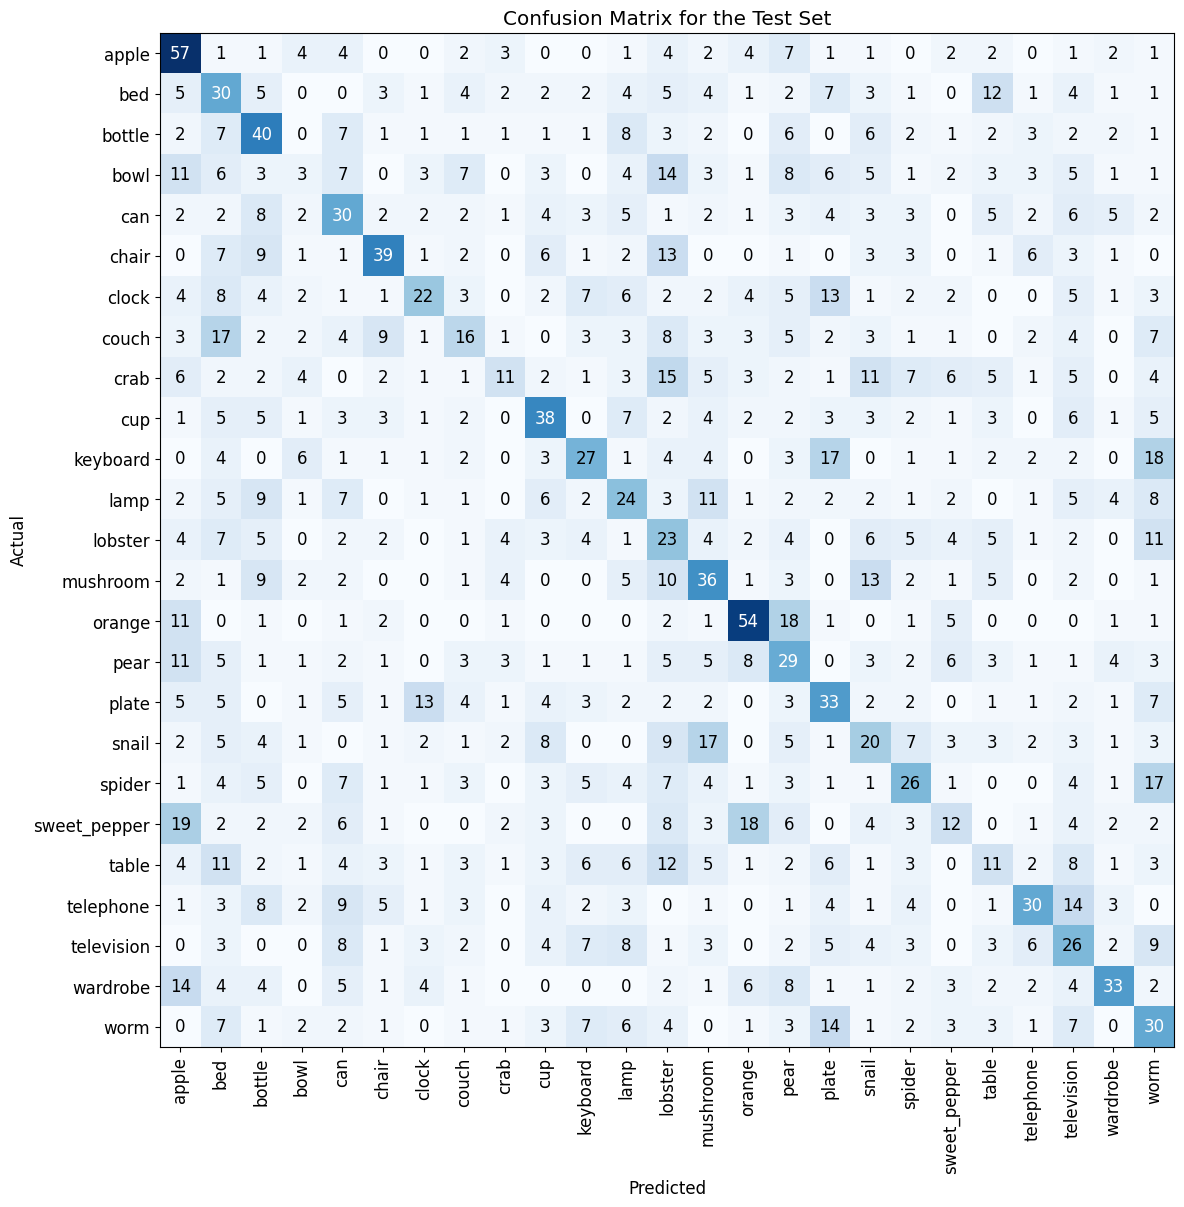

In [ ]:
# We compute the confusion matrix
interp = ClassificationInterpretation.from_learner(learn, 1, test_dl)
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

Vemos que tiene una tasa de acierto bastante pobre.
Destacamos que algunas de las clasificaciones más erróneas incluyen castores, nutrias, mapaches, focas y cocodrilos. Es comprensible que haya confusión en estos animales, especialmente en los primeros cuatro, dado que comparten características similares. Llama la atención cómo confunde a un tren con un dinosario, esto ya sí no tiene perdón de Dios.

Por otro lado, las clasificaciones más acertadas son:
- Ballena (whale), aunque ocasionalmente clasifica a los delfines y focas como tal, lo cual suele ser menos preciso, especialmente en el caso de las focas.
- Mofeta (skunk).
- Bus, a pesar de que a veces puede confundirlo con un tren, lo cual es comprensible.
- Motocicleta, que podríamos considerar como la categoría mejor clasificada, ya que, aunque su tasa de acierto no sea la más alta, raramente se confunden otros objetos con ella.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.178606,3.117517,0.081600,0.918400,00:30
1,2.990511,2.924017,0.154800,0.845200,00:31
2,2.776333,2.733564,0.212800,0.787200,00:31
3,2.634894,2.617332,0.240800,0.759200,00:29
4,2.537193,2.538138,0.270000,0.730000,00:32
5,2.456639,2.500045,0.272800,0.727200,00:28
6,2.378979,2.468088,0.291600,0.708400,00:26
7,2.337869,2.442518,0.297200,0.702800,00:28
8,2.291265,2.414291,0.304000,0.696000,00:27
9,2.248703,2.408493,0.309600,0.690400,00:30


Better model found at epoch 0 with valid_loss value: 3.11751651763916.


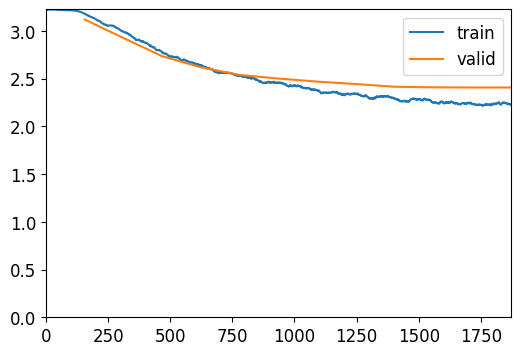

Better model found at epoch 1 with valid_loss value: 2.9240171909332275.
Better model found at epoch 2 with valid_loss value: 2.7335636615753174.
Better model found at epoch 3 with valid_loss value: 2.6173322200775146.
Better model found at epoch 4 with valid_loss value: 2.5381383895874023.
Better model found at epoch 5 with valid_loss value: 2.50004506111145.
Better model found at epoch 6 with valid_loss value: 2.468088388442993.
Better model found at epoch 7 with valid_loss value: 2.4425179958343506.
Better model found at epoch 8 with valid_loss value: 2.4142913818359375.
Better model found at epoch 9 with valid_loss value: 2.4084932804107666.
Better model found at epoch 10 with valid_loss value: 2.4065656661987305.
Better model found at epoch 11 with valid_loss value: 2.4064791202545166.


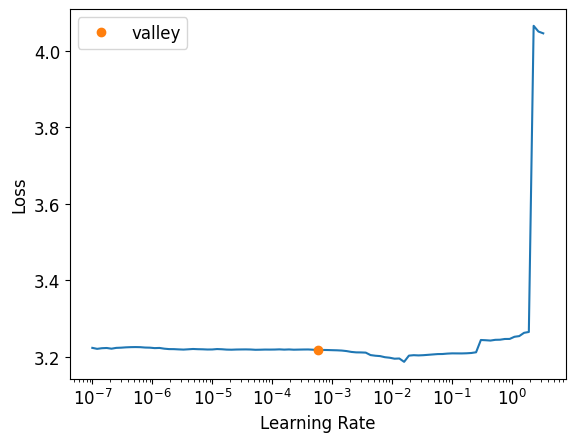

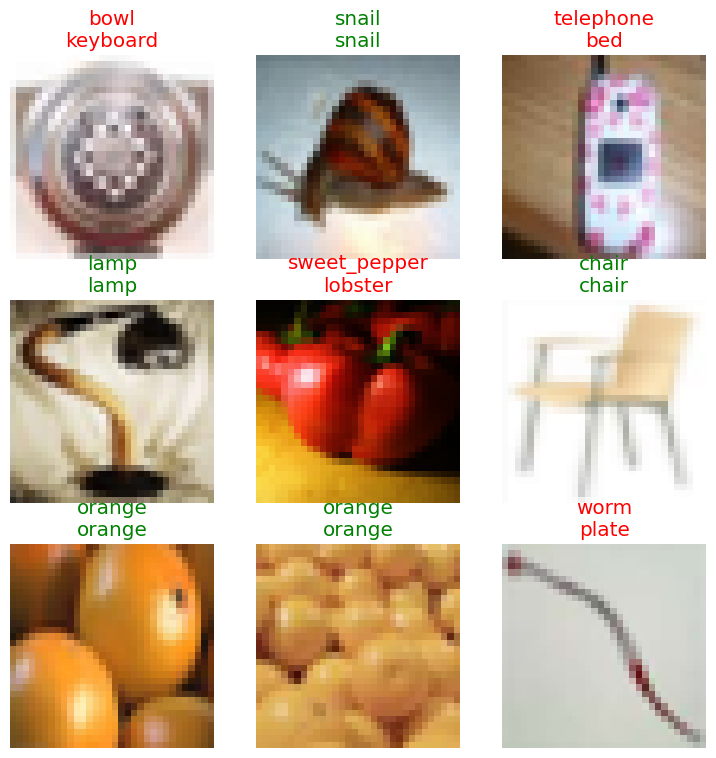

In [ ]:
learn_alt = Learner(CIFAR100, BaseNET(), loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,error_rate])
lr=learn_alt.lr_find()
cbs=[SaveModelCallback(), ShowGraphCallback()]
learn_alt.fit_one_cycle(n_epoch=12, lr_max=lr[0], cbs=cbs)
learn_alt.show_results()

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Number of test examples: 2500


Test Accuracy
30.28


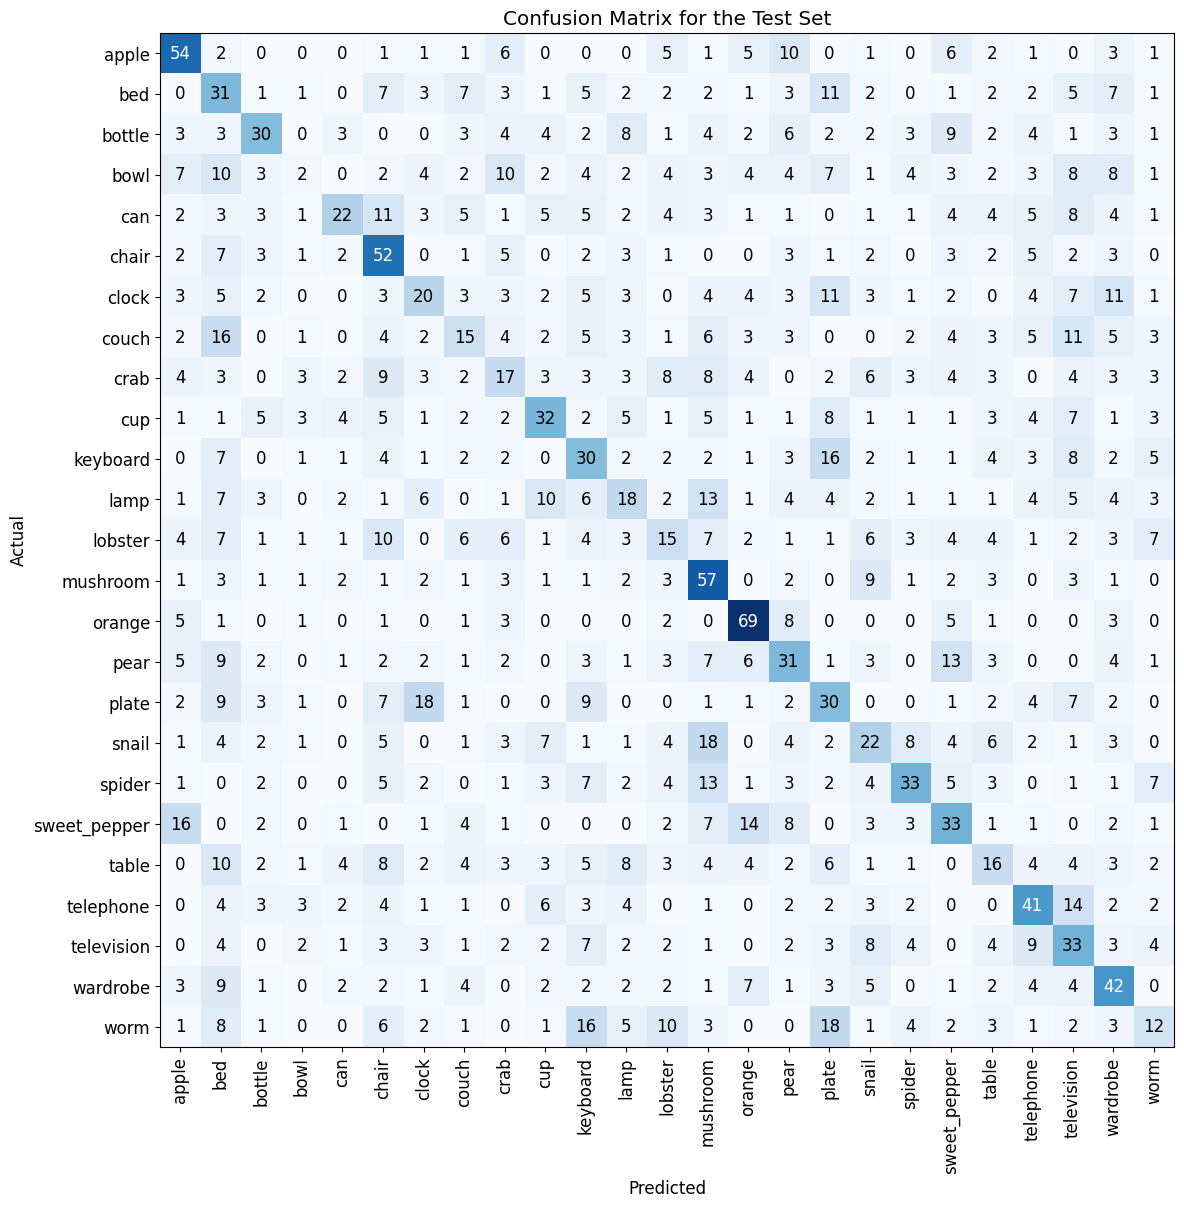

In [ ]:
# We perform prediction on this bunch of data (in this case, the test set)
preds, targs, _ = learn_alt.get_preds(dl=test_dl, with_decoded=True)

# We compute the confusion matrix
interp = ClassificationInterpretation.from_learner(learn_alt, 1, test_dl)
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

<font color=#80BEF1>What is the total number of parameters of the created model? Break down the account made to reach that figure.



**CÁLCULO DE NÚMERO DE PARÁMETROS ENTRENABLES**

a. **Conv2D (1):**

$$
\begin{align*}
\text{# Learnable parameters}
&= \text{# Learnable parameters from filters} + \text{# Learnable parameters from bias}
\\
&= C_{out} \times C_{in} \times K_W \times K_H + C_{out} = 4 \times 3 \times 7 \times 7 + 4 = 592
\end{align*}
$$

b. **MaxPool2D :** No tiene parámetros a calcular.

c. **Conv2D (2):**  

$$
\begin{align*}
\text{# Learnable parameters}
&= \text{# Learnable parameters from filters} + \text{# Learnable parameters from bias}
\\
&= C_{out} \times C_{in} \times K_W \times K_H + C_{out} = 10 \times 4 \times 5 \times 5 + 10 = 1.010
\end{align*}
$$

d. **Flatten**: No tiene parámetros a calcular.

d. **Fully Connected (1):**

$$
\begin{align*}
\text{# Learnable parameters}
&= \text{# Learnable params. for linear combination} + \text{# Learnable params. for bias}
\\
&= n_{\text{neuronas entrada}} \times n_{\text{neuronas salida}} + n_{\text{neuronas salida}} = 810 \times 50 + 50 = 40.550
\end{align*}
$$

e. **Fully Connected (2):**

$$
\begin{align*}
\text{# Learnable parameters}
&= \text{# Learnable params. for linear combination} + \text{# Learnable params. for bias}
\\
&= n_{\text{neuronas entrada}} \times n_{\text{neuronas salida}} + n_{\text{neuronas salida}} = 50 \times 25 + 25 = 1.275
\end{align*}
$$

<font color=#80BEF1>When fastai is used, and a multiclass classification problem like the one indicated in this exercise is addressed, is it necessary to incorporate a SoftMax function (`nn.Softmax()`) as last layer/element/component of your model? Justify the answer.

En la inicialización del Learner, incluye por defecto la función de activación Softmax al final de la red neuronal:

> Depending on the loss_func attribute of Learner, an activation function will be picked automatically so that the predictions make sense. For instance **if the loss is a case of cross-entropy, a softmax will be applied**, or if the loss is binary cross entropy with logits, a sigmoid will be applied. If you want to make sure a certain activation function is applied, you can pass it with act. - Documentación de fastai (https://docs.fast.ai/learner.html)



---



---



---



# <font color=#80BEF1> **Exercise 2:** **Improvement of the BaseNet model (3.5 points)**
<font color=#80BEF1>Now the goal is to create, by making judicious architectural and implementation choices, an enhanced deep network based on *BaseNet*. Students should perform a sensible combination of different elements, which may include all or some of the following: Convolutional layers (Conv2D, either normal or atrous), Pooling layers (Local and Global MaxPooling2D and AveragePooling2D), Dense layers (also called fully-connected (FC) layers), Non-linear activations, (e.g. ReLu, leaky ReLu, etc.), Flattening (i.e. convert 2D features to 1D features),  Batch Normalization, and/or Regularization (e.g. Dropout or weight decay).

<font color=#80BEF1>It is necessary to emphasize that **it is essential to justify the decisions made in the best possible way** (either through empirical evidence or through scientific literature).

<font color=#80BEF1>A good combination of layers can largely improve the performance of our new model on these data. To enhance your network, you may consider adding any combination of the following enhancement options:
1. **Data normalization**. Scale normalization of the input data, in general, makes training easier and more robust. Use the DataLoader or ImageDataLoaders class with the correct parameters so that the data is well conditioned (mean=0, stddev=1) to improve training. You must ensure that test_transform uses the same normalization parameters as train_transform.
2. **Batch normalization**. Batch-normalization layers in most cases help to reduce overfitting and improve model training. Add normalization layers after convolutional layers and before the ReLU layer, but try including it after ReLU layers as well.
3. **Depth increase**. Experiment adding convolutional layers. Do not always put a maxpool layer after each conv layer, as this leads to excessive loss of information by reducing the number of units. If needed use UpSampling (Transposed Convolution) layers to increase the number of units.
4. **Dropout**. This layer introduces regularization by randomly selecting a percentage of active neurons for each mini-batch. This helps the network to specialize neurons in specific and independent information.
5. **Early Stopping**. After how many epochs we should stop training? Keep in mind that you should never use the test set for anything other than the final evaluation. You should decide for how many epochs you will train your model by looking at the training loss and validation accuracy plots (to do so, evaluate the local minima/maxima of the loss function as well as the classification accuracy). Remember that if you choose too many epochs it would quite likely lead to overfitting, while if you select too few your model quite likely won't  learn enough. In your report, you must include a table similar to the one shown in Exercise 1 to illustrate the architecture of your final improved network. In addition, you must explain the steps taken with the partial results obtained that have finally led you to introduce the proposed modifications.
6. **Data augmentation**.  Use the DataLoader or ImageDataLoaders class data zoom parameters, like zoom_range and/or horizontal_flip. Remember that you should not have any data augmentation in the validation or test sets. If you need a better understanding, try reading fastai's tutorial on transformations. Look at data augmentation using image transformations.

<font color=#80BEF1> Feel free to incorporate modifications not included in the aforementioned list.

In [ ]:
CIFAR100 = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            splitter=RandomSplitter(valid_pct=0.2, seed=42),
            get_y=parent_label,
            item_tfms=[Resize((32,32), method='squish')],
            batch_tfms=[Normalize.from_stats(*imagenet_stats),
                        *aug_transforms()]
          ).dataloaders(path/'train')

  Hemos aplicado una transformación adicional a los datos:
  - **Aumento de datos (*Data Augmentation*)**: Esta transformación introduce variaciones artificiales aleatorias en las imágenes, como rotaciones, inversiones horizontales, zoom en regiones aleatorias, ... Esto ayudará al modelo a generalizar mejor y ser más robusto frente a estas mismas alteraciones en los datos de entreada.

In [ ]:
class ImprovedNET(nn.Sequential):

    def __init__(self):
        super().__init__(

            # Primer bloque convolucional (32x32 | 16x16)
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Segundo bloque convolucional (16x16 | 8x8)
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Tercer bloque convolucional (8x8 | 4x4)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Aplanado (4x4 | 16)
            nn.Flatten(),

            # Primer bloque fully-connected
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4*4*256, out_features=4*256),
            nn.ReLU(),

            # Segundo bloque fully-connected
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4*256, out_features=256),
            nn.ReLU(),

            # Tercer bloque fully-connected
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),

            # Cuarto bloque fully-connected
            nn.Linear(in_features=64, out_features=25)
        )

# object instantiation
ImprovedNET_model = ImprovedNET()

Se ha mejorado la red realizando las siguientes acciones:

- **Añadir capa de normalización en lote tras la ReLU**: Esta capa normaliza las  activaciones de una red neuronal durante el entrenamiento. Su propósito principal es mitigar el problema de *internal covariate shift*, que es el cambio en la distribución de las actividades de una capa a medida que la red neuronal aprende durante el entrenamiento.

  La normalización por lotes (Batch Normalization) aborda este problema normalizando las activaciones de una capa alrededor de cero y escalándolas para tener una desviación estándar de uno. La fórmula básica de la normalización por lotes es la siguiente:

  $$
  BatchNorm2d(x)=
  \frac{x-mean(x)}{\sqrt{Var(x)+\epsilon}}​ \times \gamma + \beta
  $$
  donde:
  - $x$ son las activaciones de la capa.
  - $mean(x)$ y $Var(x)$ son la media y la varianza de $x$ en un lote.
  - $\gamma$ y $\beta$ son parámetros aprendibles, y permiten que la capa de Batch Normalization aprenda la mejor escala y desplazamiento para las activaciones normalizadas, lo que proporciona a la red más flexibilidad y capacidad de representación.
  - $\epsilon$ es una pequeña constante añadida para evitar la división por cero.

- **Añadir Dropout**: El *dropout* es una técnica de regularización para prevenir el sobreajuste (*overfitting*). La idea es introducir aleatoriamente la desconexión temporal de neuronas durante el entrenamiento, evitando que ciertas neuronas de la red dependan demasiado de otras neuronas específicas durante el proceso de aprendizaje.

  Durante cada paso de entrenamiento, cada neurona tiene una probabilidad predefinida de ser "eliminada" temporalmente, es decir, sus salidas se establecen en cero. Esta probabilidad es un hiperparámetro, que yo, por ejemplo, he decidido poner a 0.5.

  Colocar el Dropout antes de la capa lineal (fully-connected) permite que durante cada paso de entrenamiento, se excluya aleatoriamente un subconjunto de unidades, lo que obliga a la red a aprender patrones más robustos y generalizables.

- **Aumentar la profundidad de la red y el número de neuronas en cada capa:**
Una expansión en la arquitectura de la red aumentará tanto su capacidad para reconocer características específicas, como su capacidad para aprender patrones más complejos de los datos.

  Incrementar el número de neuronas convolucionales y capas de este tipo facilitará el aprendizaje para detectar una mayor variedad de características y patrones distintivos. Del mismo modo, en el caso de las capas fully-connected, aumentar tanto el número de neuronas como de capas posibilitará que la red adquiera conocimientos sobre combinaciones lineales más complejas.

In [ ]:
learn = Learner(CIFAR100, ImprovedNET_model, loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,error_rate])
learn.summary()

ImprovedNET (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 32 x 32   
Conv2d                                    9472       True      
ReLU                                                           
BatchNorm2d                               128        True      
Conv2d                                    200768     True      
ReLU                                                           
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 64 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 16 x 16  
Conv2d                                    204928     True      
ReLU                                                           
BatchNorm2d                         

Hemos evolucionado del modelo `BaseNET`, con 43.427 parámetros entrenables, a `ImprovedNET`, con más de 6.187.737, manteniendo apróximadamente la proporción de capas fully-connected sobre la red. Veamos si este aumento de la complejidad del modelo logra una mayor robustez en su desempeño.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.186494,3.104627,0.110800,0.889200,00:23
1,2.960303,2.769809,0.167600,0.832400,00:23
2,2.752601,2.569756,0.240400,0.759600,00:22
3,2.592167,2.501821,0.270000,0.730000,00:23
4,2.411934,2.212506,0.343200,0.656800,00:22
5,2.287411,2.167111,0.361600,0.638400,00:22
6,2.152884,2.028412,0.406800,0.593200,00:24
7,2.019419,2.010523,0.418000,0.582000,00:23
8,1.913669,1.765494,0.467200,0.532800,00:22
9,1.824713,1.717371,0.481200,0.518800,00:25


Better model found at epoch 0 with valid_loss value: 3.1046273708343506.


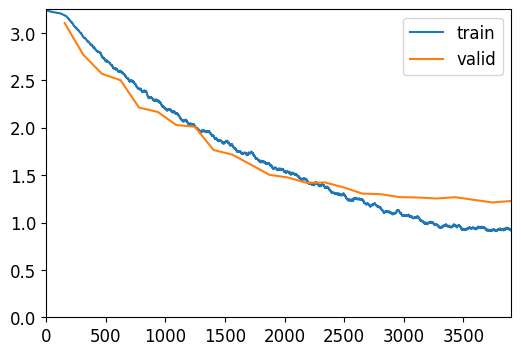

Better model found at epoch 1 with valid_loss value: 2.7698094844818115.
Better model found at epoch 2 with valid_loss value: 2.5697555541992188.
Better model found at epoch 3 with valid_loss value: 2.501821279525757.
Better model found at epoch 4 with valid_loss value: 2.21250581741333.
Better model found at epoch 5 with valid_loss value: 2.167111396789551.
Better model found at epoch 6 with valid_loss value: 2.028412103652954.
Better model found at epoch 7 with valid_loss value: 2.0105230808258057.
Better model found at epoch 8 with valid_loss value: 1.7654943466186523.
Better model found at epoch 9 with valid_loss value: 1.7173714637756348.
Better model found at epoch 10 with valid_loss value: 1.6118539571762085.
Better model found at epoch 11 with valid_loss value: 1.50357985496521.
Better model found at epoch 12 with valid_loss value: 1.4752334356307983.
Better model found at epoch 13 with valid_loss value: 1.4185510873794556.
Better model found at epoch 15 with valid_loss value: 

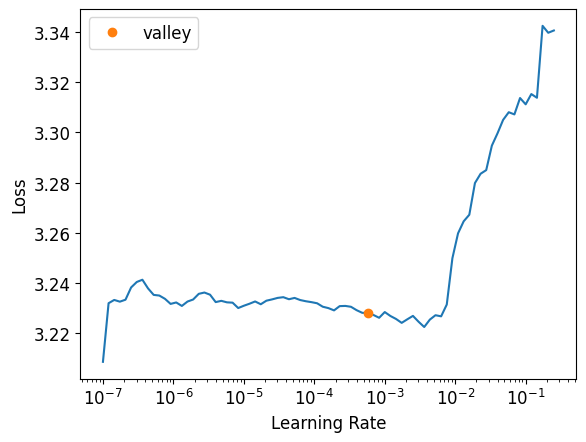

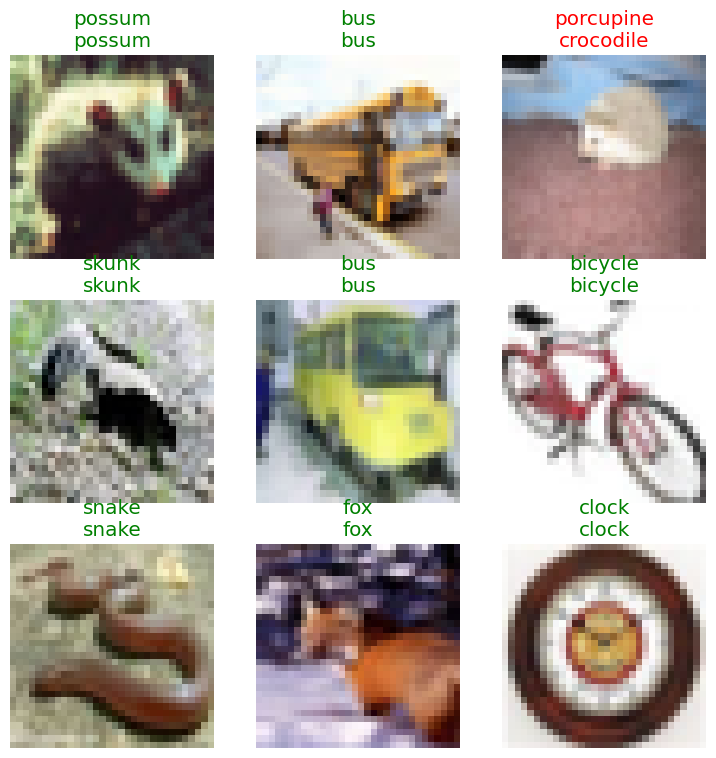

In [ ]:
lr=learn.lr_find()
cbs=[SaveModelCallback(), ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn.fit_one_cycle(n_epoch=25, lr_max=lr[0], cbs=cbs)
learn.show_results()

Los resultados de este proceso de entrenamiento muestran una notable mejoría. En primer lugar, la **tasa de aciertos ha alcanzado el 64,5%**, prácticamente duplicando la tasa obtenida con `BaseNET`. Además, se observa que la regularización lograda por Dropout ha conseguido retrasar el sobreajuste hasta aproximadamente la iteración 2.500. Este logro sugiere una **mayor capacidad del modelo para generalizar patrones** a partir de los datos de entrenamiento, lo cual es esencial para mejorar el rendimiento en conjuntos de datos no vistos.

Number of test examples: 2500


Test Accuracy
62.28


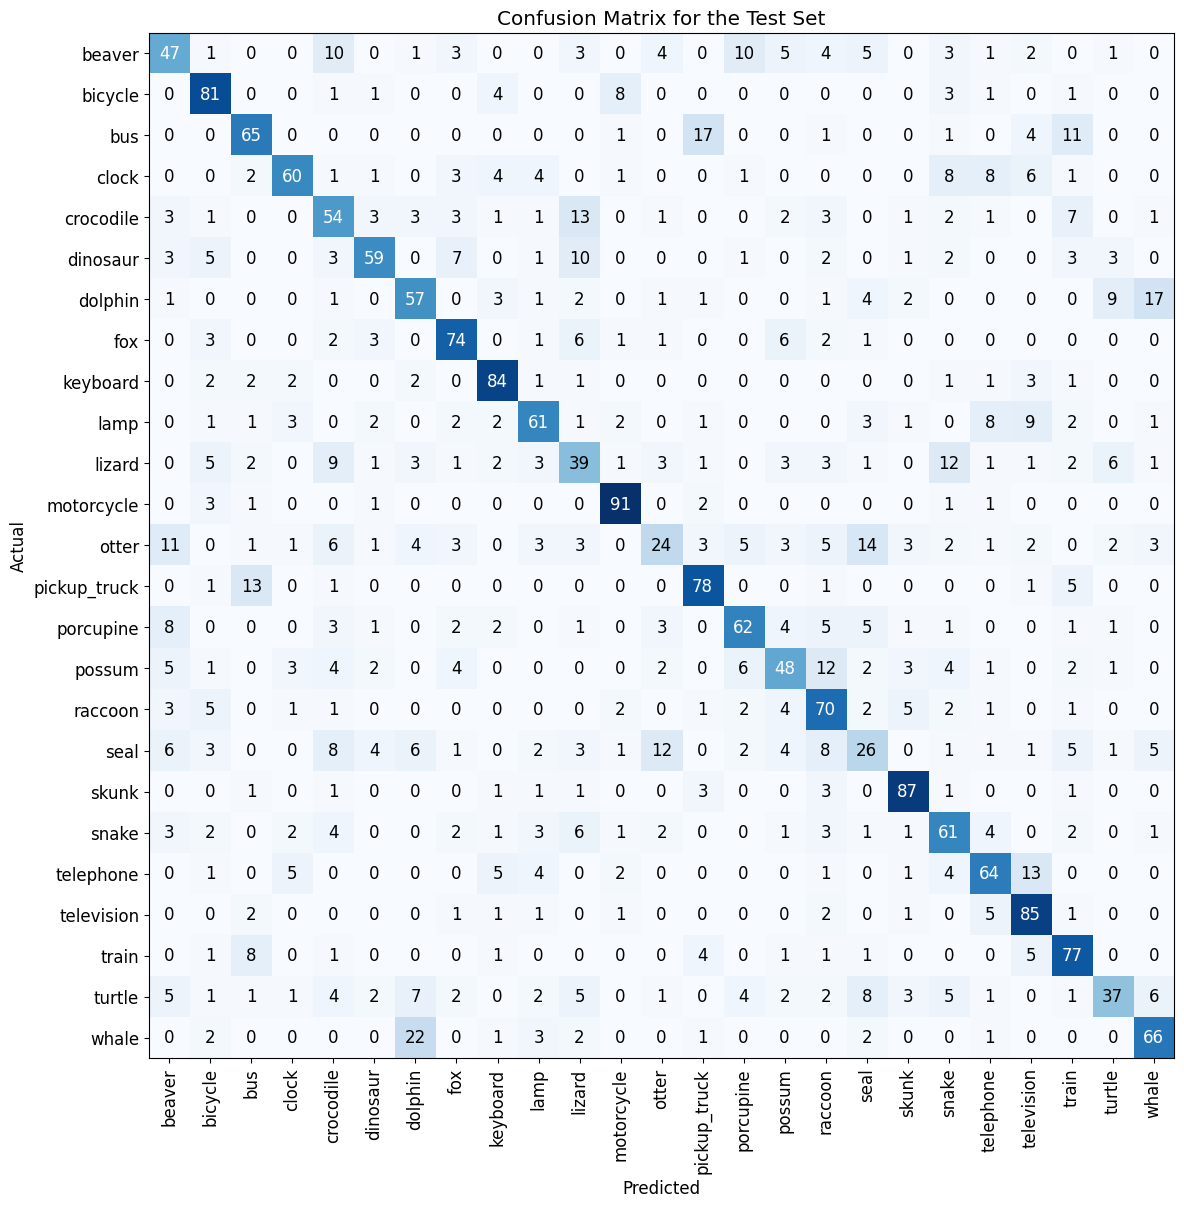

In [ ]:
# We perform prediction on this bunch of data (in this case, the test set)
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

# We compute the confusion matrix
interp = ClassificationInterpretation.from_learner(learn, 1, test_dl)
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

`ImprovedNET` entrenado presenta una tasa de acierto significativamente superior a `BaseNET`. Las bajas tasas de acierto se concentran en:

- Confusión entre nutrias, focas y castores, lo que es comprensible, al ser animales con características similares, como forma (alargados) y color (marrones y/o gris).
- Confusión entre largartos y serpientes, de la misma forma, comprensible, dada su forma alargada y colores llamativos.

En contraste, la motocicleta se destaca como el objeto mejor clasificado, posiblemente gracias a sus características distintivas y fácilmente identificables.